In [1]:
#Import necessary libraries  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.datasets import make_blobs  
from sklearn.preprocessing import StandardScaler  
from sklearn.cluster import DBSCAN  
from sklearn.metrics import silhouette_score, calinski_harabasz_score  
from sklearn.decomposition import PCA

In [2]:
# Set random seeds for reproducibility  
np.random.seed(42) 

In [3]:
#Dataset Preparation  
# Generate synthetic dataset  
X, _ = make_blobs(n_samples=10000, centers=6, cluster_std=[0.5, 1.0, 1.5, 2.0, 0.8, 1.2], random_state=42)  


In [4]:
# Add random noise points  
noise = np.random.uniform(low=-15, high=15, size=(200, X.shape[1]))  
X = np.vstack([X, noise])  


In [5]:
#Feature Engineering  
# Calculate derived features  
euclidean_distance = np.linalg.norm(X, axis=1)  
product_of_features = X[:, 0] * X[:, 1]  


In [6]:
# Stack features into a new array  
X_enhanced = np.column_stack((X, euclidean_distance, product_of_features))  

# Normalize all features using Standard Scaling  
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X_enhanced)  


In [7]:
# DBSCAN Clustering and Parameter Tuning  
eps_values = np.arange(0.01, 0.2, 0.01)  
min_samples_values = range(2, 16, 2)  

# Initialize data structures to store metrics  
silhouette_scores = []  
calinski_scores = []  

# Define function to compute clustering performance  
def compute_clustering_metrics(eps, min_samples):  
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)  
    labels = dbscan.fit_predict(X_scaled)  
    
    # Only compute metrics for clusters (not noise, which is labeled as -1)  
    if len(set(labels)) > 1:  # more than 1 cluster  
        silhouette = silhouette_score(X_scaled, labels)  
        calinski = calinski_harabasz_score(X_scaled, labels)  
    else:  
        silhouette = -1  # Assign -1 if no clusters found  
        calinski = -1  

    return silhouette, calinski  

# Loop through parameters to compute metrics  
for eps in eps_values:  
    silhouette_col = []  
    calinski_col = []  
    for min_s in min_samples_values:  
        silhouette, calinski = compute_clustering_metrics(eps, min_s)  
        silhouette_col.append(silhouette)  
        calinski_col.append(calinski)  
    
    silhouette_scores.append(silhouette_col)  
    calinski_scores.append(calinski_col)  

# Converting metrics to DataFrames for heatmap visualization  
silhouette_df = pd.DataFrame(silhouette_scores, columns=min_samples_values, index=eps_values)  
calinski_df = pd.DataFrame(calinski_scores, columns=min_samples_values, index=eps_values)

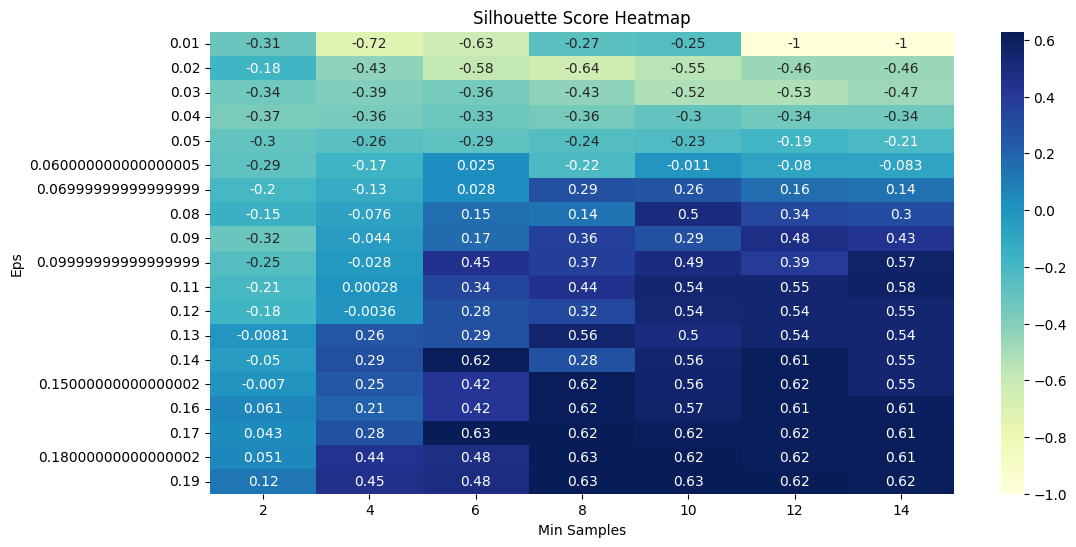

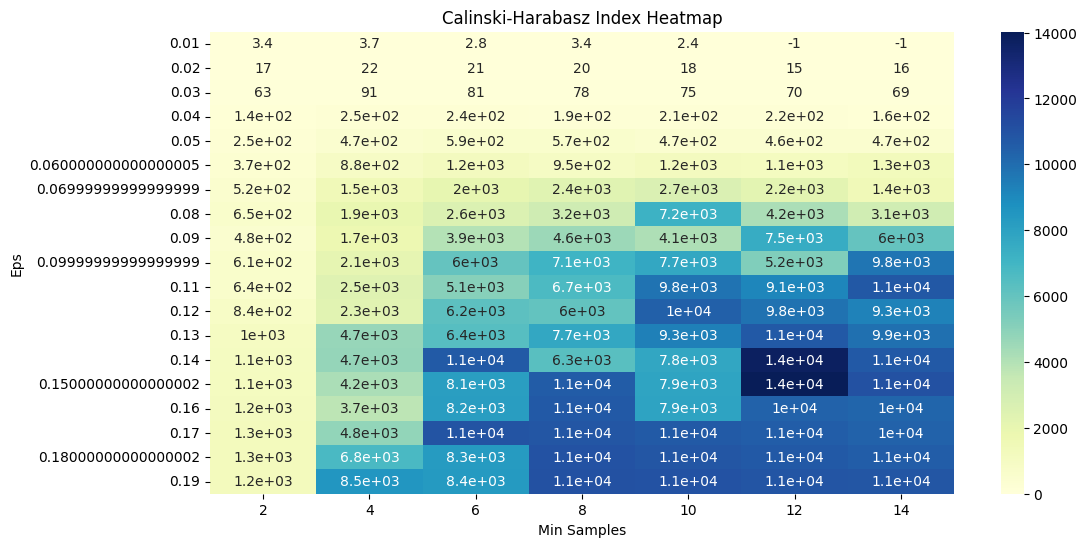

Best parameters for Silhouette Score: eps = 0.19, min_samples = 8
Best parameters for Calinski-Harabasz Index: eps = 0.15000000000000002, min_samples = 12


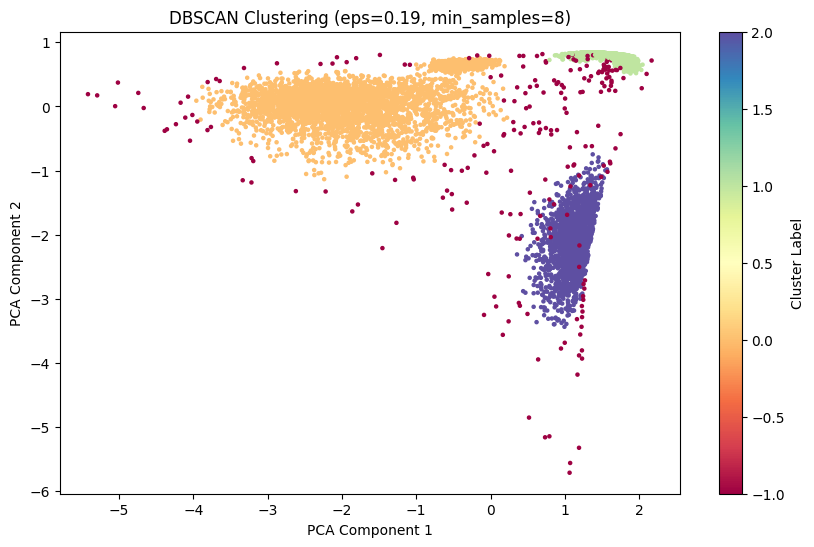

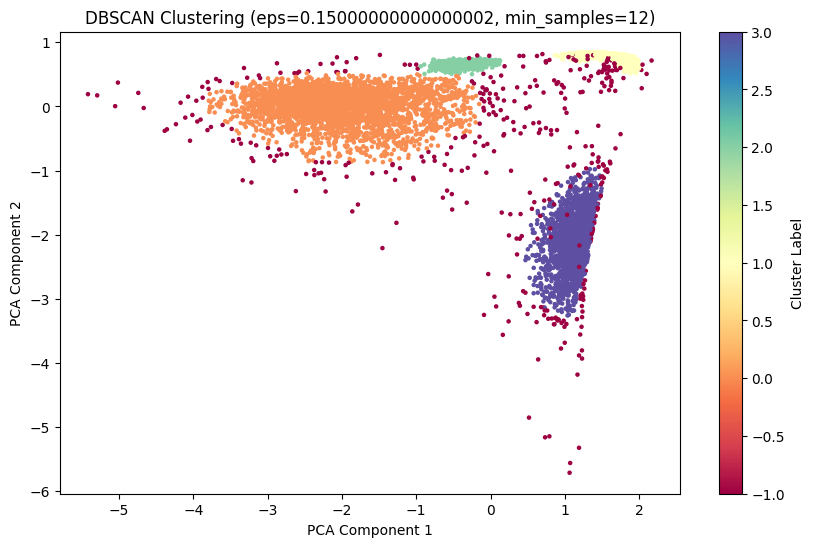

In [8]:
# Heatmaps of the metrics  
plt.figure(figsize=(12, 6))  
plt.title("Silhouette Score Heatmap")  
sns.heatmap(silhouette_df, annot=True, cmap='YlGnBu', cbar=True)  
plt.xlabel('Min Samples')  
plt.ylabel('Eps')  
plt.show()  

plt.figure(figsize=(12, 6))  
plt.title("Calinski-Harabasz Index Heatmap")  
sns.heatmap(calinski_df, annot=True, cmap='YlGnBu', cbar=True)  
plt.xlabel('Min Samples')  
plt.ylabel('Eps')  
plt.show()  

# Identify the best parameter combinations  
best_silhouette = np.unravel_index(np.argmax(silhouette_df.values, axis=None), silhouette_df.shape)  
best_calinski = np.unravel_index(np.argmax(calinski_df.values, axis=None), calinski_df.shape)  

best_eps_silhouette = eps_values[best_silhouette[0]]  
best_min_samples_silhouette = min_samples_values[best_silhouette[1]]  

best_eps_calinski = eps_values[best_calinski[0]]  
best_min_samples_calinski = min_samples_values[best_calinski[1]]  

print(f"Best parameters for Silhouette Score: eps = {best_eps_silhouette}, min_samples = {best_min_samples_silhouette}")  
print(f"Best parameters for Calinski-Harabasz Index: eps = {best_eps_calinski}, min_samples = {best_min_samples_calinski}")  

# Visualize results for the best parameter combinations  
def visualize_clusters(eps, min_samples):  
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)  
    labels = dbscan.fit_predict(X_scaled)  
    
    # Reduce dimensions for visualization  
    pca = PCA(n_components=2)  
    X_pca = pca.fit_transform(X_scaled)  

    plt.figure(figsize=(10, 6))  
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Spectral', s=5)  
    plt.title(f"DBSCAN Clustering (eps={eps}, min_samples={min_samples})")  
    plt.xlabel('PCA Component 1')  
    plt.ylabel('PCA Component 2')  
    plt.colorbar(label='Cluster Label')  
    plt.show()  

# Visualize clustering for the best parameters (Silhouette Score)  
visualize_clusters(best_eps_silhouette, best_min_samples_silhouette)  

# Visualize clustering for the best parameters (Calinski-Harabasz Index)  
visualize_clusters(best_eps_calinski, best_min_samples_calinski)  
